In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets list


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'google'

In [2]:
! kaggle datasets download -d vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images

 91% 217M/238M [00:02<00:00, 93.1MB/s]
100% 238M/238M [00:02<00:00, 109MB/s] 


In [3]:
! unzip pharmaceutical-drugs-and-vitamins-synthetic-images.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005002.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005003.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005004.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005005.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005006.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005007.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005008.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005009.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005010.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005011.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005012.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw

# CNN

In [4]:
! rmdir /content/'Drug Vision'/'Data Combined'/.ipynb_checkpoints

# ! rmdir /content/'Drug Vision'/'Data Combined'/'Neozep'
# ! rmdir /content/'Drug Vision'/'Data Combined'/'Medicol'
# ! rmdir /content/'Drug Vision'/'Data Combined'/'Kremil S'
# ! rmdir /content/'Drug Vision'/'Data Combined'/'Fish Oil'
# ! rmdir /content/'Drug Vision'/'Data Combined'/'Decolgen'
# ! rmdir /content/'Drug Vision'/'Data Combined'/'DayZinc'

rmdir: failed to remove '/content/Drug Vision/Data Combined/.ipynb_checkpoints': No such file or directory


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

In [9]:
classes = os.listdir('./Drug Vision/Data Combined')
num_classes = len(classes)
classes

['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic']

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

dataset = torchvision.datasets.ImageFolder(root='./Drug Vision/Data Combined', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


classes = os.listdir('./Drug Vision/Data Combined')

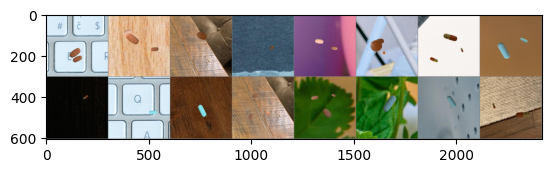

Biogesic Biogesic Bactidol Bactidol Biogesic Bactidol Alaxan Bioflu Alaxan Bioflu Bioflu Biogesic Biogesic Bioflu Bioflu Alaxan


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# функция для показа изображения
def imshow(img):
    img = img  / 2  + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# получаем несколько случайных обучающих изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# показать изображения
imshow(torchvision.utils.make_grid(images))
# показать лейблы изображений
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# Инициализация модели
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (in_channels, out_channels, kernel_size) Применяет 2D-свертку к входному сигналу, состоящему из нескольких входных плоскостей.
        self.pool = nn.MaxPool2d(2, 2) # (kernel_size, stride) Применяет MaxPool2D-объединение к входному сигналу, состоящему из нескольких входных плоскостей.
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 72 * 72, 120 )# (in_features , out_features) Применяет линейное преобразование к входящим данным
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    # Это forward функция, которая определяет структуру сети.
    # Здесь мы принимаем только один вход, но можно использовать больше.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) #(input, start_dim) Сглаживает input путем преобразования его в одномерный тензор.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [13]:
class Regulator(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(Regulator,self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
        )
            
    def forward(self,x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = nn.ReLU(True)(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            Regulator(64,64),
        )
        
        self.block3 = nn.Sequential(
            Regulator(64,128,2),
        )
        
        self.block4 = nn.Sequential(
            Regulator(128,256,2),
        )
        self.block5 = nn.Sequential(
            Regulator(256,512,2),
        )
        self.maxpool = nn.MaxPool2d(2, 2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512*10*10, num_classes)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.maxpool(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return torch.log_softmax(x, dim=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net2 = Net2().to(device)

In [30]:
class Regulator(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(Regulator,self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        super(Net3,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            Regulator(64,64),
        )
        
        self.block3 = nn.Sequential(
            Regulator(64,128,2),
        )
        
        self.block4 = nn.Sequential(
            Regulator(128,256,2),
        )
        self.block5 = nn.Sequential(
            Regulator(256,512,2),
        )
        self.maxpool = nn.MaxPool2d(2, 2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512*10*10, num_classes)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.maxpool(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return torch.log_softmax(x, dim=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net3 = Net3().to(device)

In [31]:
device

device(type='cpu')

In [15]:
class Regulator(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(Regulator,self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

class Net4(nn.Module):
    def __init__(self):
        super(Net4,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.droput = nn.Dropout(p=0.5) 
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            Regulator(64,64),
        )
        self.droput = nn.Dropout(p=0.5) 
        self.block3 = nn.Sequential(
            Regulator(64,128,2),
        )
        self.droput = nn.Dropout(p=0.5) 
        self.block4 = nn.Sequential(
            Regulator(128,256,2),
        )
        self.block5 = nn.Sequential(
            Regulator(256,512,2),
        )
        self.maxpool = nn.MaxPool2d(2, 2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512*10*10, num_classes)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.droput(x)
        x = self.block2(x)
        x = self.droput(x)
        x = self.block3(x)
        x = self.droput(x)
        x = self.block4(x)
        x = self.droput(x)
        x = self.block5(x)
        x = self.maxpool(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return torch.log_softmax(x, dim=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net4 = Net4().to(device)

In [16]:
batch = next(iter(trainloader))

Net4().forward(torch.FloatTensor(batch[0]))

tensor([[-1.7067, -0.6078, -2.0610, -1.9196],
        [-1.1362, -1.3776, -1.5417, -1.5475],
        [-1.2170, -1.1746, -1.4402, -1.8448],
        [-1.4884, -0.8907, -1.7423, -1.6672],
        [-1.1495, -1.2630, -1.3458, -1.9656],
        [-1.5030, -1.0521, -1.6940, -1.4083],
        [-1.5654, -0.9654, -1.2274, -2.1447],
        [-1.1783, -0.9613, -1.9751, -1.7657],
        [-1.3230, -1.3319, -1.8738, -1.1516],
        [-1.2556, -1.2847, -1.7001, -1.3638],
        [-0.1260, -2.5053, -3.3486, -6.4335],
        [-1.1900, -1.3638, -1.4681, -1.5619],
        [-3.1702, -0.2349, -2.1974, -2.8782],
        [-0.9534, -1.2847, -1.8507, -1.7108],
        [-1.0029, -1.3462, -2.0324, -1.4190],
        [-0.6998, -1.3909, -2.5682, -1.7273]], grad_fn=<LogSoftmaxBackward0>)

Коэффициент скорости обучения – это гиперпараметр, определяющий порядок того, как мы будем корректировать наши весы с учётом функции потерь в градиентном спуске. Чем ниже величина, тем медленнее мы движемся по наклонной. Хотя при использовании низкого коэффициента скорости обучения мы можем получить положительный эффект в том смысле, чтобы не пропустить ни одного локального минимума, — это также может означать, что нам придётся затратить много времени на cходимость, особенно если мы попали в область плато.

Импульс (momentum) в нейронных сетях — это вариант стохастического градиентного спуска . Он заменяет градиент импульсом , который представляет собой совокупность градиентов, как очень хорошо объяснено [здесь](https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9).




In [17]:
losses = {
    0: [],
    1: [],
    2: [],
    3: []
}

acc = {
    0: [],
    1: [],
    2: [],
    3: []
}

In [18]:
from torch.optim import Adam


#Критерии полезны для обучения нейронной сети. Учитывая входные данные и цель, они вычисляют градиент в соответствии с заданной функцией потерь
criterion = nn.CrossEntropyLoss()

In [36]:
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(40):  # многократное прохождение по набору данных

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
            losses[0].append(running_loss)
            running_loss = 0.0
          
        correct = 0
        total = 0
        if i % 200 == 199:
          with torch.no_grad():
            for data in testloader:
                images, labels = data
                # рассчитываем выходные данные, пропуская изображения через сеть
                outputs = net(images.to(device))
                # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to(device) == labels.to(device)).sum().item()
            print(f'Net 1: {100 * correct // total} %')
            acc[0].append(correct // total)

print('Finished Training')

[1,   100] loss: 100.28148126602173
[1,   200] loss: 100.2927457690239
Net 1: 44 %
[2,   100] loss: 89.19407719373703
[2,   200] loss: 97.39900976419449
Net 1: 46 %
[3,   100] loss: 89.02451127767563
[3,   200] loss: 90.37601155042648
Net 1: 49 %
[4,   100] loss: 87.0822884440422
[4,   200] loss: 84.89632904529572
Net 1: 46 %
[5,   100] loss: 85.40432405471802
[5,   200] loss: 87.79533898830414
Net 1: 47 %
[6,   100] loss: 85.58921939134598
[6,   200] loss: 85.21637731790543
Net 1: 50 %
[7,   100] loss: 83.383445084095
[7,   200] loss: 83.33261039853096
Net 1: 46 %
[8,   100] loss: 80.19492411613464
[8,   200] loss: 79.44797804951668
Net 1: 53 %
[9,   100] loss: 55.921329736709595
[9,   200] loss: 58.560938119888306
Net 1: 54 %
[10,   100] loss: 33.181639444082975
[10,   200] loss: 31.513489481061697
Net 1: 51 %
[11,   100] loss: 18.30594851821661
[11,   200] loss: 18.719353523105383
Net 1: 53 %
[12,   100] loss: 14.57851636223495
[12,   200] loss: 16.956786561524495
Net 1: 52 %
[13,  

In [37]:
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = Adam(net2.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(40):  # многократное прохождение по набору данных

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        if i % 100 == 99:    # вывести каждые 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
            losses[1].append(running_loss)
            running_loss = 0.0
          
        correct = 0
        total = 0
        if i % 200 == 199:
          with torch.no_grad():
            for data in testloader:
                images, labels = data
                # рассчитываем выходные данные, пропуская изображения через сеть
                outputs = net2(images.to(device))
                # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to(device) == labels.to(device)).sum().item()
            print(f'Net 2: {100 * correct // total} %')
            acc[1].append(correct // total)

print('Finished Training')

[1,   100] loss: 138.66691839694977
[1,   200] loss: 138.64256238937378
Net 2: 23 %
[2,   100] loss: 138.63309478759766
[2,   200] loss: 138.65087485313416
Net 2: 23 %
[3,   100] loss: 138.6506873369217
[3,   200] loss: 138.63390958309174
Net 2: 23 %
[4,   100] loss: 138.62970113754272
[4,   200] loss: 138.6454871892929
Net 2: 23 %
[5,   100] loss: 138.62756669521332
[5,   200] loss: 138.6687971353531
Net 2: 23 %
[6,   100] loss: 138.6510373353958
[6,   200] loss: 138.62936174869537
Net 2: 23 %
[7,   100] loss: 138.63145101070404
[7,   200] loss: 138.64592218399048
Net 2: 23 %
[8,   100] loss: 138.63804602622986
[8,   200] loss: 138.65450477600098
Net 2: 23 %
[9,   100] loss: 138.64226591587067
[9,   200] loss: 138.6462664604187
Net 2: 23 %
[10,   100] loss: 138.6285763978958
[10,   200] loss: 138.66376495361328
Net 2: 23 %
[11,   100] loss: 138.6519457101822
[11,   200] loss: 138.63262009620667
Net 2: 23 %
[12,   100] loss: 138.60705041885376
[12,   200] loss: 138.68742752075195
Net 2

In [ ]:
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = Adam(net3.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(40):  # многократное прохождение по набору данных

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        if i % 100 == 99:    # вывести каждые 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
            losses[2].append(running_loss)
            running_loss = 0.0
        
        correct = 0
        total = 0
        if i % 200 == 199:
          with torch.no_grad():
            for data in testloader:
                images, labels = data
                # рассчитываем выходные данные, пропуская изображения через сеть
                outputs = net3(images.to(device))
                # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to(device) == labels.to(device)).sum().item()
            print(f'Net 3: {100 * correct // total} %')
            acc[2].append(correct // total)

print('Finished Training')

In [ ]:
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = Adam(net4.parameters(), lr=0.001, weight_decay=0.0001)

for epoch in range(40):  # многократное прохождение по набору данных

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем входные данные; данные - это список [inputs, labels].
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        running_loss += loss.item()
        if i % 100 == 99:    # вывести каждые 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
            losses[3].append(running_loss)
            running_loss = 0.0
        
        correct = 0
        total = 0
        if i % 200 == 199:
          with torch.no_grad():
            for data in testloader:
                images, labels = data
                # рассчитываем выходные данные, пропуская изображения через сеть
                outputs = net4(images.to(device))
                # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.to(device) == labels.to(device)).sum().item()
            print(f'Net 4: {100 * correct // total} %')
            acc[3].append(correct // total)

print('Finished Training')

In [77]:
#Сохранение нашей модели
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
torch.save(net2.state_dict(), PATH)
torch.save(net3.state_dict(), PATH)
torch.save(net4.state_dict(), PATH)

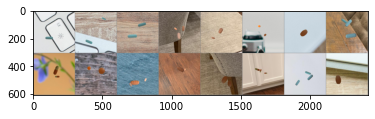

GroundTruth:  Bactidol Bactidol Bactidol Bioflu Bioflu Alaxan Alaxan Bactidol Biogesic Alaxan Bioflu Bioflu Alaxan Biogesic Bactidol Alaxan


In [78]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# вывод изображений
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [79]:
net = Net()
net2 = Net2()
net3 = Net3()
net4 = Net4()
net.load_state_dict(torch.load(PATH))
nets = [net, net2, net3, net4]

In [80]:
outputs = net(images)

In [81]:
correct = 0
total = 0
numof = -1
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for net_elem in nets:
      for data in testloader:
          images, labels = data
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = net_elem(images)
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      numof += 1
      print(f'Net {numof}: {100 * correct // total} %')

Net 0: 49 %
Net 1: 37 %


In [83]:
# Подготовка

numof = -1
for net_elem in nets:
  numof += 1
  print(f'Net {numof}')
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes} 
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net_elem(images)
          _, predictions = torch.max(outputs, 1)
          # собираем правильные прогнозы для каждого класса
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # Выводим точность на каждом классе
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Net 0
Accuracy for class: Biogesic is 41.2 %
Accuracy for class: Alaxan is 37.4 %
Accuracy for class: Bactidol is 84.4 %
Accuracy for class: Bioflu is 37.6 %
Net 1
Accuracy for class: Biogesic is 0.0 %
Accuracy for class: Alaxan is 100.0 %
Accuracy for class: Bactidol is 0.0 %
Accuracy for class: Bioflu is 0.0 %
